In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm
from nmc import nmc

In [2]:
x0 = np.array([[8, 0, 30]]).T
end_time = 10
dt = 0.01
ts = np.arange(0, end_time, dt)

nature = lorenz63_fdm(x0, ts)
nature.shape

(3, 1000)

In [7]:
Pb = nmc(lorenz63_fdm, nature, dt, 1, 0.04)
Pb

array([[ 4.73717948,  4.75041996, -0.34008987],
       [ 4.75041996,  6.89585908,  0.95678376],
       [-0.34008987,  0.95678376,  2.91952971]])

In [8]:
obs_intv = 8
obs = nature + np.sqrt(2) * np.random.randn(*nature.shape)
obs = obs[:,::obs_intv]
obs.shape

(3, 125)

In [9]:
R = np.eye(3) * 2
R

array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]])

In [10]:
# a very bad initial condition
X_ini = x0 + np.array([[10, -10, 15]]).T
X_ini

array([[ 18],
       [-10],
       [ 45]])

In [11]:
N_ens = 30
X_ens_ini = np.random.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (ndim, N_ens)
X_ens_ini.shape

(3, 30)

In [12]:
def da_rmse(nature, analysis, obs_intv):
    return np.sqrt(np.mean((analysis[:,::obs_intv] - nature[:,::obs_intv]) ** 2, axis=0))

def plot_assimilation_result(nature, obs, analysis, obs_intv):
    fig, axs = plt.subplots(nrows=4, figsize=(8, 8), sharex=True)
    for i in range(3):
        axs[i].plot(ts, nature[i,:], color='#024BC7', label='nature')
        axs[i].plot(ts[::obs_intv], obs[i,:], '.', color='#024BC7', label='obs')
        axs[i].plot(ts, analysis[i,:], color='#FFA500', label='analysis')
    axs[0].legend()
    axs[0].set_title('X')
    axs[1].set_title('Y')
    axs[2].set_title('Z')
    
    rmse = da_rmse(nature, analysis, obs_intv)
    axs[3].plot(ts[::obs_intv], rmse, '.-')
    axs[3].set_title('RMSE')
    
    plt.tight_layout()

In [13]:
from scipy.linalg import sqrtm
from assimilation import EnKF

class EAKF(EnKF):
    def _analysis(self, xb, yo, R, H_func=None, loc_mo=None, loc_oo=None):
        if H_func is None:
            H_func = lambda arr: arr
            
        N_ens = xb.shape[1]
        xb_mean = xb.mean(axis=1)[:,np.newaxis]   # (ndim_xb, 1)
        xb_pertb = xb - xb_mean   # (ndim_xb, N_ens)
        
        # assimilate ensemble mean
        Hxb_mean = H_func(xb).mean(axis=1)[:,np.newaxis]   # (ndim_yo, 1)
        Hxb_pertb = H_func(xb) - Hxb_mean   # (ndim_yo, N_ens)
        PfH_T = xb_pertb @ Hxb_pertb.T / (N_ens-1)
        HPfH_T = Hxb_pertb @ Hxb_pertb.T / (N_ens-1)
        K = PfH_T @ np.linalg.inv(HPfH_T + R)
        xa_mean = xb_mean + K @ (yo - H_func(xb_mean))
        
        # assimilate ensemble perturbation
        Pf = xb_pertb @ xb_pertb.T / (N_ens-1)
        eigval, F = np.linalg.eig(Pf)
        G = np.diag(np.sqrt(eigval))
        HF = H_func(F)   # ???????????????
        eigval, C = np.linalg.eig(G @ HF.T @ np.linalg.inv(R) @ HF @ G)
        S = np.diag(eigval)
        n = G.shape[0]
        A = F @ G @ C @ np.linalg.inv(sqrtm(np.eye(n)+S) @ np.linalg.inv(G) @ F.T)
        xa_pertb = A @ xb_pertb
        
        xa = xa_mean + xa_pertb
        return xa

In [14]:
eakf = EAKF(lorenz63_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.4,
    'inflat': 1.5,
}
eakf.set_params(**params)
eakf.cycle()

C:\Users\ChunYehLu\AppData\Local\Continuum\anaconda3\envs\as\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in matmul
  app.launch_new_instance()
C:\Users\ChunYehLu\AppData\Local\Continuum\anaconda3\envs\as\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
C:\Users\ChunYehLu\AppData\Local\Continuum\anaconda3\envs\as\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in matmul


LinAlgError: Array must not contain infs or NaNs

In [15]:
A = np.diag([4] * 100)
A

array([[4, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 4, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 4, 0, 0],
       [0, 0, 0, ..., 0, 4, 0],
       [0, 0, 0, ..., 0, 0, 4]])

In [16]:
#%%timeit
sqrtm(A)

array([[2., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 2.]])

In [17]:
#%%timeit
np.diag(np.sqrt(np.diagonal(A)))

array([[2., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 2.]])

In [18]:
from scipy.linalg import sqrtm, diagsvd
from assimilation import EnKF

class EAKF(EnKF):
    def _set_H(self, H):
        self.H = H
        
    def _analysis(self, xb, yo, R, H_func=None, loc_mo=None, loc_oo=None):
        if H_func is None:
            H_func = lambda arr: arr
            
        N_x, N_ens = xb.shape
        xb_mean = xb.mean(axis=1)[:,np.newaxis]   # (ndim_xb, 1)
        xb_pertb = xb - xb_mean   # (ndim_xb, N_ens)
        
        # assimilate ensemble mean
        Hxb_mean = H_func(xb).mean(axis=1)[:,np.newaxis]   # (ndim_yo, 1)
        Hxb_pertb = H_func(xb) - Hxb_mean   # (ndim_yo, N_ens)
        PfH_T = xb_pertb @ Hxb_pertb.T / (N_ens-1)
        HPfH_T = Hxb_pertb @ Hxb_pertb.T / (N_ens-1)
        K = PfH_T @ np.linalg.inv(HPfH_T + R)
        xa_mean = xb_mean + K @ (yo - H_func(xb_mean))
        
        # assimilate ensemble perturbation
        F, S, F_T = np.linalg.svd(xb_pertb)
        S = diagsvd(S, N_x, N_ens)
        G = sqrtm(S @ S.T)
        V, Dsvd, U_T = np.linalg.svd(np.linalg.inv(sqrtm(R)) @ self.H @ F @ G)
        Dsvd = diagsvd(Dsvd, yo.size, N_x)
        D = Dsvd.T @ Dsvd
        B = np.linalg.inv(sqrtm(np.eye(N_x) + D))
        A = np.linalg.inv(F.T) @ G.T @ np.linalg.inv(U_T) @ B.T @ np.linalg.inv(G.T) @ F.T
        xa_pertb = A.T @ xb_pertb
        
        xa = xa_mean + xa_pertb
        return xa

In [19]:
eakf = EAKF(lorenz63_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.4,
    'inflat': 1.5,
}
eakf.set_params(**params)
eakf._set_H(np.eye(3))
eakf.cycle()

Mean RMSE:  9.232184650538287


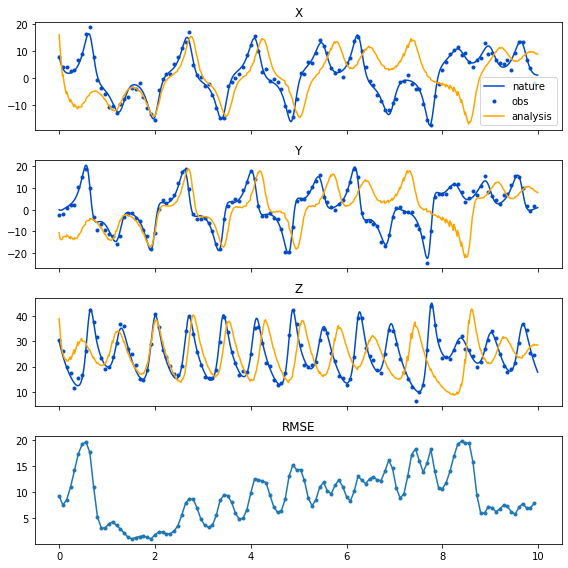

In [20]:
# use ensemble mean
analysis = eakf.analysis.mean(axis=0)
plot_assimilation_result(nature, obs, analysis, obs_intv)
print('Mean RMSE: ', da_rmse(nature, analysis, obs_intv).mean())

In [21]:
from scipy.linalg import sqrtm, diagsvd
from assimilation import EnKF

class EAKF(EnKF):        
    def _analysis(self, xb, yo, R, H_func=None, loc_mo=None, loc_oo=None):
        if H_func is None:
            H_func = lambda arr: arr
            
        Nx, Nens = xb.shape
        Ny = yo.size        
        xa = xb.copy()
        
        # assimilating one model state variable and one observation at a time
        for i in range(Nx):
            for j in range(Ny):
                # (prior) joint state vector
                Z = np.empty((2, Nens))
                Z[0,:] = xa[i,:]
                Z[1,:] = H_func(xa)[j]
                
                z_mean_p = Z.mean(axis=1)[:,np.newaxis]   # (2, 1)
                Sigma_p = np.cov(Z)   # (2, 2)
                H = np.array([[0, 1]])
                Rj = np.array([[R[j,j]]])
                yj = yo[[j]]
                
                # update ensemble mean
                #Sigma_u = np.linalg.inv(np.linalg.inv(Sigma_p) + H.T @ np.linalg.inv(Rj) @ H)
                Sigma_u = Sigma_p - Sigma_p @ H.T @ np.linalg.inv(Rj + H @ Sigma_p @ H.T) @ H @ Sigma_p
                z_mean_u = Sigma_u @ (np.linalg.inv(Sigma_p) @ z_mean_p + H.T @ np.linalg.inv(Rj) @ yj)
                
                # update ensemble perturb and get analysis result
                F, D_p, F_T = np.linalg.svd(Sigma_p)
                D_p = diagsvd(D_p, 2, 2)
                G = np.sqrt(D_p)
                U, D_u, U_T = np.linalg.svd(G.T @ F.T @ H.T @ np.linalg.inv(Rj) @ H @ F @ G)
                B = np.diag(1 / np.sqrt(1+D_u))
                A = np.linalg.inv(F.T) @ G.T @ np.linalg.inv(U_T) @ B.T @ np.linalg.inv(G.T) @ F.T
                Z_u = A.T @ (Z - z_mean_p) + z_mean_u
                
                # store
                xa[i,:] = Z_u[0,:]
                
        print(yo.ravel())
        print(xb.mean(axis=1))
        print(xa.mean(axis=1))
        print()
        return xa

In [22]:
eakf = EAKF(lorenz63_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.4,
    'inflat': 1.5,
}
eakf.set_params(**params)
eakf.cycle()

LinAlgError: Singular matrix

In [23]:
# use ensemble mean
analysis = eakf.analysis.mean(axis=0)
plot_assimilation_result(nature, obs, analysis, obs_intv)
print('Mean RMSE: ', da_rmse(nature, analysis, obs_intv).mean())

AttributeError: 'EAKF' object has no attribute 'analysis'

In [24]:
from assimilation import EnKF

class EAKF(EnKF):        
    def _analysis(self, xb, yo, R, H_func=None, loc_mo=None, loc_oo=None):
        if H_func is None:
            H_func = lambda arr: arr
            
        N_x, N_ens = xb.shape
        
        # serially assimilation
        xa = xb.copy()
        for io, iyo in enumerate(yo):
            ### step 1
            # estimate background field at the observation space
            yp = np.empty(N_ens)
            for iens in range(N_ens):
                yp[iens] = H_func(xa[:,[iens]])[io]
                
            # analysis for the background field at the observation space
            yp_mean = yp.mean()
            yp_var = yp.var()
            r = R[io,io]
            yu_var = 1 / (1/yp_var + 1/r)
            yu_mean = yu_var * (yp_mean / yp_var + iyo / r)
            yu = np.sqrt(yu_var / yp_var) * (yp - yp_mean) + yu_mean   # (N_ens,)
            increment_y = yu - yp   # (N_ens,)
            
            ### step 2 
            for jstate in range(N_x):
                cov_xy = np.cov(xa[jstate,:], yp)[0,1]
                increment_x = cov_xy / yp_var * increment_y
                xa[jstate,:] = xa[jstate,:] + loc_mo[jstate,io] * increment_x
                
        return xa

In [25]:
eakf = EAKF(lorenz63_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.4,
    'inflat': 1.5,
}
eakf.set_params(**params)
eakf.cycle()

Mean RMSE:  0.8867656764678206


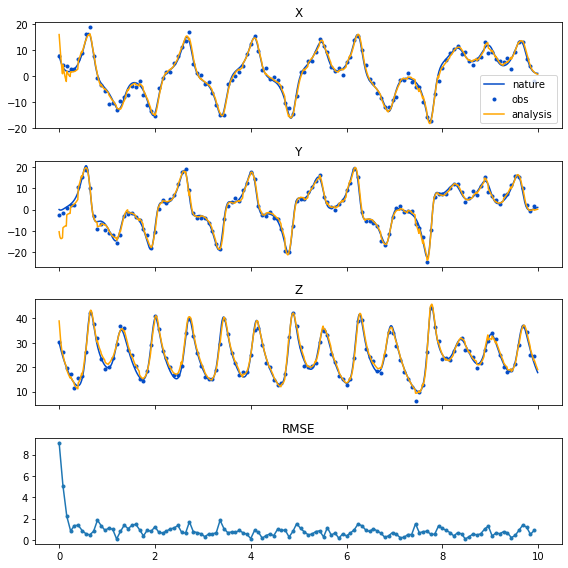

In [26]:
# use ensemble mean
analysis = eakf.analysis.mean(axis=0)
plot_assimilation_result(nature, obs, analysis, obs_intv)
print('Mean RMSE: ', da_rmse(nature, analysis, obs_intv).mean())

### test localization

In [27]:
from model import lorenz96_fdm

x0 = np.random.randint(low=0, high=9, size=40)
x0 = x0[:,np.newaxis]  # (40, 1)
end_time = 10
dt = 0.01
ts = np.arange(0, end_time, dt)
nature = lorenz96_fdm(x0, ts)

Pb = nmc(lorenz96_fdm, nature, dt, 1, 0.1)

obs_intv = 8
obs = nature + np.sqrt(2) * np.random.randn(*nature.shape)
obs = obs[:,::obs_intv]

R = np.eye(40) * 2

X_ini = x0 + np.random.randint(-15, 15, size=x0.shape)
N_ens = 30
X_ens_ini = np.random.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (ndim, N_ens)

In [28]:
# no localization
eakf = EAKF(lorenz96_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.4,
    'inflat': 1.5,
}
eakf.set_params(**params)
eakf.cycle()

Mean RMSE:  1.2381381344262647


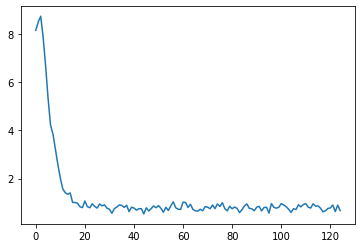

In [29]:
analysis = eakf.analysis.mean(axis=0)
rmse = da_rmse(nature, analysis, obs_intv)
plt.plot(rmse)
print('Mean RMSE: ', rmse.mean())

In [30]:
### with localization

def dis_oo(i, j, L=2):
    if j < i:
        i, j = j, i
    dis_idx = j - i
    if dis_idx > 20:
        dis_idx = 40 - dis_idx
    return np.exp(-dis_idx**2 / (2*L**2))

def dis_mo(i, j, L=2):
    return dis_oo(i, j, L)

# localization for model to observation
loc1 = np.zeros((40, 40))
for i in range(40):
    for j in range(40):
        loc1[i,j] = dis_mo(i, j)
        
# localization for observation to observation
loc2 = np.zeros((40, 40))
for i in range(40):
    for j in range(40):
        loc2[i,j] = dis_oo(i, j)

In [31]:
eakf = EAKF(lorenz96_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.4,
    'inflat': 1.5,
    'local_mo': loc1
}
eakf.set_params(**params)
eakf.cycle()

Mean RMSE:  0.8787669726899425


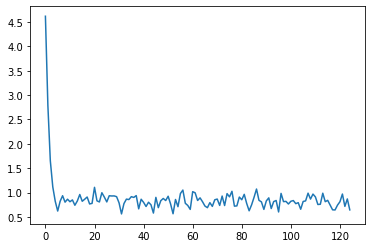

In [32]:
analysis = eakf.analysis.mean(axis=0)
rmse = da_rmse(nature, analysis, obs_intv)
plt.plot(rmse)
print('Mean RMSE: ', rmse.mean())